In [25]:
import pandas as pd

df = pd.read_csv('dados_arduino_2.csv', encoding='ISO-8859-1')
df = df.head(100)
display(df)

,Tempo_µs,Ciclo_CPU,Referencia_Motor,Vel_Real
0,416.0,384.0,0.0,0.0
1,892.0,476.0,0.0,0.0
2,1380.0,488.0,0.0,0.0
3,1900.0,516.0,0.0,0.0
4,2432.0,536.0,0.0,0.0
...,...,...,...,...
95,2013616.0,23920.0,375.0,910.0
96,2037612.0,23920.0,375.0,910.0
97,2061456.0,23920.0,375.0,910.0
98,2085448.0,23920.0,375.0,750.0


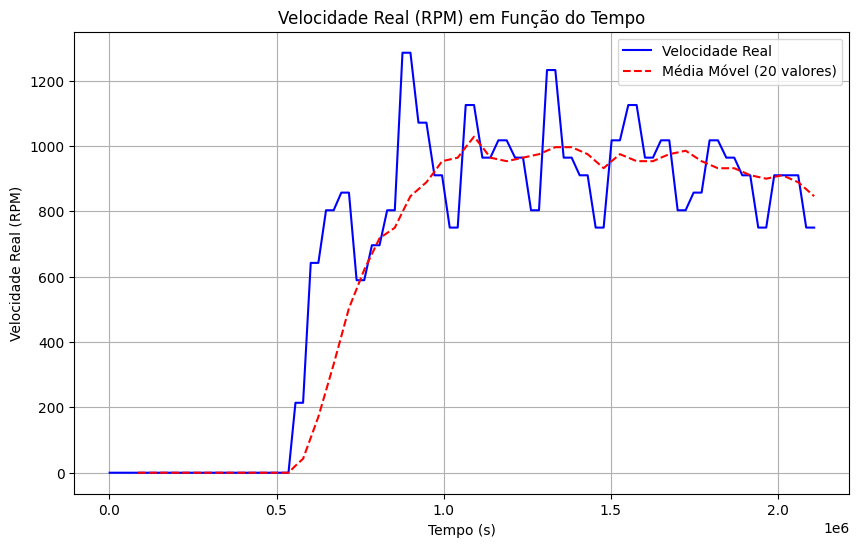

In [26]:
import matplotlib.pyplot as plt

# Calcular a média móvel de 10 valores
df['Vel_Real_Media'] = df['Vel_Real'].rolling(window=10).mean()

# Criar o gráfico
plt.figure(figsize=(10, 6))  # Tamanho da figura
plt.plot(df['Tempo_µs'], df['Vel_Real'], label='Velocidade Real', color='b')  # Gráfico original
plt.plot(df['Tempo_µs'], df['Vel_Real_Media'], label='Média Móvel (20 valores)', color='r', linestyle='--')  # Gráfico da média móvel

# Adicionar título e rótulos aos eixos
plt.title('Velocidade Real (RPM) em Função do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade Real (RPM)')

# Mostrar a legenda
plt.legend()

# Mostrar o gráfico
plt.grid(True)  # Adicionar uma grade ao gráfico
plt.show()

In [27]:
df['Vel_Real'] = df['Vel_Real_Media']
df = df[df['Vel_Real'].notna()]
df = df.reset_index(drop=True)
display(df.head()) 

,Tempo_µs,Ciclo_CPU,Referencia_Motor,Vel_Real,Vel_Real_Media
0,85440.0,17684.0,0.0,0.0,0.0
1,103140.0,17676.0,0.0,0.0,0.0
2,121840.0,18720.0,0.0,0.0,0.0
3,140560.0,18724.0,0.0,0.0,0.0
4,159300.0,18716.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
import math

# Variáveis globais
deslocamento_em_t = None
linha_deslocamento_em_t = None

# Funções

def inicio_degrau(df):
    """Busca onde ocorre o degrau (aumento significativo na variável de interesse)."""
    for i in range(1, len(df)-2):
        derivada = (df['Vel_Real'][i+1] - df['Vel_Real'][i]) / (df['Tempo_µs'][i+1] - df['Tempo_µs'][i])
        if derivada > 0:
            return i + 1
    return -1  # Caso não encontre o degrau

def buscar_regime_permanente(df):
    """Busca o regime permanente no DataFrame, onde a variável 'Vel_Real' estabiliza."""
    for i in range(50, len(df)):
        valores = df['Vel_Real'][i-5:i]  # Usando os 5 dados anteriores
        media = valores.mean()  # Média
        amplitude = valores.max() - valores.min()  # Amplitude

        if amplitude < 0.05 * media:  # Critério de estabilidade 0.05
            return i
    return -1

def buscar_primeiro_tal_interpolado(df, valor_referencia):
    """Busca o instante de tempo correspondente ao valor de 63,2% do regime permanente."""
    linha_anterior = None
    valor_anterior = df.iloc[0]['Vel_Real'] 
    print('linha anterior', linha_anterior)
    print('valor anterior', valor_anterior)
    for i, linha_atual in df.iloc[0:].iterrows(): 
        valor_atual = linha_atual['Vel_Real']
        if valor_anterior < valor_referencia <= valor_atual:
            x1 = df.iloc[i-1]['Tempo_µs']
            y1 = valor_anterior
            x2 = linha_atual['Tempo_µs']
            y2 = valor_atual
            constante_de_tempo = x1 + (valor_referencia - y1) * (x2 - x1) / (y2 - y1) - deslocamento_em_t
            return constante_de_tempo
        valor_anterior = valor_atual
        linha_anterior = linha_atual

    return -1

def curva_modelada(df, constante_de_tempo, ganho_da_exponencial, indice, titulo):
    """Gera a curva modelada com base nos parâmetros fornecidos e adiciona ao DataFrame."""
    ganho_do_degrau = df.iloc[indice]['Vel_Real']
    
    # Cria uma nova coluna no DataFrame para armazenar os valores modelados
    df[titulo] = [None] * len(df)
    
    # Preenche os dados antes do degrau
    for i in range(linha_deslocamento_em_t):
        df.loc[i, titulo] = ganho_do_degrau * (1 - ganho_da_exponencial)

    # Preenche os dados após o degrau (resposta exponencial)
    for i in range(linha_deslocamento_em_t, len(df)):
        tempo = df.iloc[i]['Tempo_µs']
        if not pd.isna(ganho_da_exponencial) and not pd.isna(constante_de_tempo):
            df.loc[i, titulo] = ganho_do_degrau * (1 - ganho_da_exponencial * math.exp(-(tempo - deslocamento_em_t) / constante_de_tempo))
        else:
            print('Valoresinválidos')

    print(f"Modelagem do Sistema de 1° Ordem: {titulo}")
    print(f"Equação: ganho_do_degrau * (1 - ganho_da_exponencial * exp(-(t - deslocamento_em_t) / constante_de_tempo))")
    print(f"Parâmetros: ganho_do_degrau = {ganho_do_degrau}, ganho_da_exponencial = {ganho_da_exponencial}, deslocamento_em_t = {deslocamento_em_t}, constante_de_tempo = {constante_de_tempo}")

# INÍCIO DO ALGORITMO

# Obtém onde a exponencial deve começar (onde ocorre o degrau)
linha_deslocamento_em_t = inicio_degrau(df)      
if linha_deslocamento_em_t != -1:
    deslocamento_em_t = df.iloc[linha_deslocamento_em_t]['Tempo_µs']
    print(f"Deslocamento em t igual a {deslocamento_em_t}")
else:
    print("Não foi possível determinar o deslocamento em t.")

# DETERMINAÇÃO DO REGIME PERMANENTE
indice_RP = buscar_regime_permanente(df)  # Índice da linha onde entra em regime permanente
if indice_RP != -1:
    print(f"Regime permanente em: {df.iloc[indice_RP]}")
else:
    print("Nenhum regime permanente encontrado.")

# SE O REGIME PERMANENTE FOR ENCONTRADO, CONTINUA A MODELAGEM
if indice_RP != -1:

    # DETERMINAÇÃO DO VALOR DE TAL
    valor_referencia = (df.iloc[indice_RP]['Vel_Real'] - df.iloc[0]['Vel_Real']) * 0.632 + df.iloc[0]['Vel_Real']

    # Método Interpolado
    if deslocamento_em_t:
        constante_de_tempo = buscar_primeiro_tal_interpolado(df, valor_referencia)
        if constante_de_tempo != -1:
            print(f"Constante de tempo interpolada para {valor_referencia} -> {constante_de_tempo}")
        else:
            print("Erro: não foi possível encontrar as duas linhas para interpolação.")

        # Calcula o ganho da exponencial
        media_antes = df['Vel_Real'][linha_deslocamento_em_t-7:linha_deslocamento_em_t].mean()
        media_depois = df['Vel_Real'][indice_RP-7:indice_RP].mean()
        print(f"Media antes do degrau: {media_antes}")
        print(f"Media no regime permanente: {media_depois}")
        ganho_da_exponencial = (df['Vel_Real'][indice_RP-12:indice_RP].mean() - df['Vel_Real'][linha_deslocamento_em_t-15:linha_deslocamento_em_t].mean())  # Média de 15 amostras antes e 15 amostras após o degrau
        
        if constante_de_tempo != -1 and deslocamento_em_t:
            print("")    
            print("Modelagem do Sistema de 1° Ordem")
            print("TIPO DA EQUAÇÃO:")
            print("velocidade_inicial + ganho_da_exponencial * (1 - e^(-(t - deslocamento_em_t) / constante_de_tempo))")
            print("VALORES DOS PARÂMETROS:")
            print(f"velocidade_inicial = {df.iloc[indice_RP]['Vel_Real'] - ganho_da_exponencial}") 
            print(f"ganho_da_exponencial = {ganho_da_exponencial}")
            print(f"deslocamento_em_t = {deslocamento_em_t}")
            print(f"constante_de_tempo = {constante_de_tempo}")

            # Chama a função de modelagem
            curva_modelada(df, constante_de_tempo, ganho_da_exponencial, indice_RP, "Resposta ao Degrau")


Deslocamento em t igual a 556648.0
Regime permanente em: Tempo_µs            1237776.0
Ciclo_CPU             23904.0
Referencia_Motor        375.0
Vel_Real                964.0
Vel_Real_Media          964.0
Name: 54, dtype: float64
linha anterior None
valor anterior 0.0
Constante de tempo interpolada para 609.248 -> 201298.0406112054
Media antes do degrau: 0.0
Media no regime permanente: 979.2428571428572

Modelagem do Sistema de 1° Ordem
TIPO DA EQUAÇÃO:
velocidade_inicial + ganho_da_exponencial * (1 - e^(-(t - deslocamento_em_t) / constante_de_tempo))
VALORES DOS PARÂMETROS:
velocidade_inicial = 2.366666666666447
ganho_da_exponencial = 961.6333333333336
deslocamento_em_t = 556648.0
constante_de_tempo = 201298.0406112054
Modelagem do Sistema de 1° Ordem: Resposta ao Degrau
Equação: ganho_do_degrau * (1 - ganho_da_exponencial * exp(-(t - deslocamento_em_t) / constante_de_tempo))
Parâmetros: ganho_do_degrau = 964.0, ganho_da_exponencial = 961.6333333333336, deslocamento_em_t = 556648.0,